In [1]:
import os

PATH = '/kaggle/input/fracture-detection-using-x-ray-images/data'
train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'val')

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)

2025-05-05 21:03:52.156757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746479032.463362      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746479032.559751      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense, Dropout
from tensorflow.keras.models import Model

base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='/kaggle/input/mobilenet-v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')
base_model.trainable = False
feature_extractor = tf.keras.Sequential([base_model, GlobalAveragePooling2D()])

2025-05-05 21:04:19.965798: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
import numpy as np
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

def extract_features(generator):
    features = []
    labels = []
    for i in range(len(generator)):
        batch_images, batch_labels = generator[i]
        batch_features = feature_extractor.predict(batch_images, verbose=0)
        features.extend(batch_features)
        labels.extend(batch_labels)
    return np.array(features), np.array(labels)


X_train, y_train = extract_features(train_generator)
X_val, y_val = extract_features(val_generator)

y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

In [5]:
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

model = KNeighborsClassifier(n_neighbors=19, metric='euclidean', n_jobs=-1)

start_time = time.time()
model.fit(X_train, y_train)
train_time = time.time() - start_time
print(f"Temps d'entraînement: {train_time:.2f} secondes")

start_time = time.time()
pred_val = model.predict(X_val)
inference_time = time.time() - start_time
print(f"Temps d'inférence (ensemble de validation): {inference_time:.2f} secondes")
print(f"Temps moyen par image: {inference_time/len(X_val)*1000:.2f} ms")

print("Accuracy:", accuracy_score(y_val, pred_val))
print(classification_report(y_val, pred_val))

Temps d'entraînement: 0.01 secondes
Temps d'inférence (ensemble de validation): 0.34 secondes
Temps moyen par image: 0.56 ms
Accuracy: 0.705
              precision    recall  f1-score   support

           0       0.90      0.57      0.70       360
           1       0.58      0.90      0.71       240

    accuracy                           0.70       600
   macro avg       0.74      0.74      0.70       600
weighted avg       0.77      0.70      0.70       600



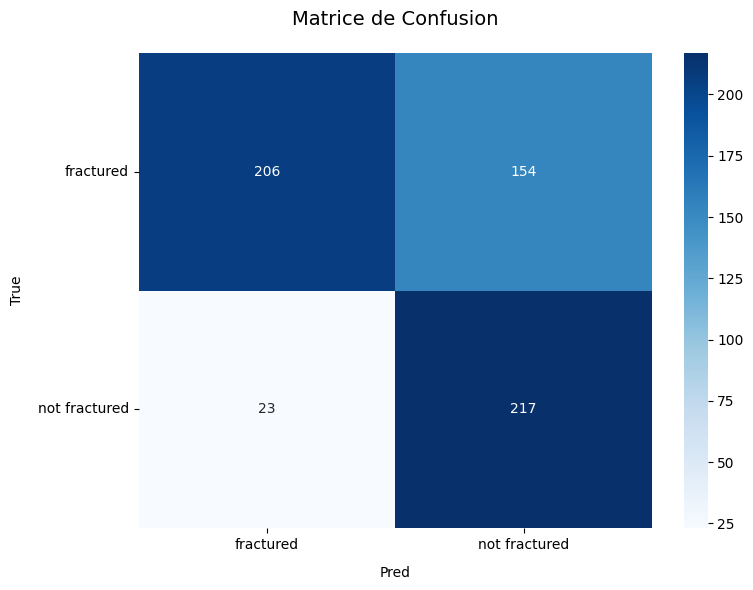

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

CLASS_NAMES = list(train_generator.class_indices.keys())
cm = confusion_matrix(y_val, pred_val)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)

plt.title('Matrice de Confusion', pad=20, fontsize=14)
plt.xlabel('Pred', labelpad=10)
plt.ylabel('True', labelpad=10)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()